<a href="https://colab.research.google.com/github/liepstik/git_moves/blob/master/projet_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents

>[Subject](#scrollTo=vAlLussbpwC4)

>>[Context](#scrollTo=ZRR2FKEa2hqj)

>>>[NER](#scrollTo=8HjW0OX8tqO9)

>>[Work to be done](#scrollTo=v5b86Ce1fOgG)

>>[Rendering](#scrollTo=89q49GkAguBh)

>[Prerequisite](#scrollTo=xxYiALfPniZC)

>>[Simple transformers, wandb Installation](#scrollTo=s9TjSfEKXUm9)

>>[APEX Installation](#scrollTo=EvuQROz_jN4h)

>>[Importing libraries](#scrollTo=Kzju3uBK2weP)

>>[Mounting drive](#scrollTo=4c6mCMi8i2KP)

>[Dataframe creation](#scrollTo=4O9DiLdHUsuZ)

>>[Gain time](#scrollTo=QBzJbdW4qYET)

>>[Data processing](#scrollTo=9Mmj4X3wrvDG)

>>>[Processing related to simpletransformer](#scrollTo=9OQWnpScHV13)

>>>[Checking that each word has only one label associated](#scrollTo=dfZ0st3cksMT)

>>>[Export of the processed dataframe (df)](#scrollTo=uXkOqwlAwETG)

>>>[Creation of training and testing datasets](#scrollTo=OkyipPUxLUnY)

>[Descriptive analysis](#scrollTo=g4cmlGsxn5qV)

>[Testing available NERmodels of simpletransformer.](#scrollTo=q4J6-WU_zIRw)

>>[Functions](#scrollTo=yfzCbusmmLbR)

>>[Training and evaluation of each Model](#scrollTo=WgyBBjwmbaSm)

>>[Focus on Camembert](#scrollTo=M6RjMWksc3tI)

>>>[Processing results](#scrollTo=KfhdtGWJ4VG4)

>>[Predictions](#scrollTo=-bCMdgSrBfU3)

>[Classification report](#scrollTo=ZrY5Q3K-Cq69)



# Subject

## Context


French language models have recently been published (CamemBERT, FlauBERT). This is positive because even advanced tools like Spacy are notoriously still ill-suited to deal with certain languages, including French. It remains to be assessed what these models can really bring, particularly with regard to the recognition of named entities.



### NER 
https://simpletransformers.ai/docs/ner-specifics/

"The goal of Named Entity Recognition is to locate and classify named entities in a sequence. The named entities are pre-defined categories chosen according to the use case such as names of people, organizations, places, codes, time notations, monetary values, etc. Essentially, NER aims to assign a class to each token (usually a single word) in a sequence. Because of this, NER is also referred to as token classification."

**How to use Simple Transformer**

* Initialize a NERModel
* Train the model with train_model()
* Evaluate the model with eval_model()
* Make predictions on (unlabelled) data with predict()

**Models available to supply to model_type** : https://huggingface.co/models

* BERT :	*bert*
* CamemBERT :	*camembert*
* RoBERTa :	*roberta*
* DistilBERT :	*distilbert*
* ELECTRA	: *electra*
* XLM-RoBERTa	: *xlmroberta*

## Work to be done

Perform recognition experiments on named entities on the Europeana Newspapers French data set using all the models available for this in the Simple Transformers library. The addresses to consult are:

* https://github.com/ThilinaRajapakse/simpletransformers
* http://api.bnf.fr/europeana-newspapers-french-ner-ground-truth

## Rendering

Clear and commented code in a notebook.
A report describing the evaluation methods / metrics (based on seqeval, a detailed description of which will be given) and presenting / comparing / discussing the results obtained.


# Prerequisite

This section contains the installations and library imports needed to make the code work.

## Simple transformers, wandb Installation 

In [0]:
pip install simpletransformers

In [0]:
pip install wandb

## APEX Installation

Apex is a PyTorch add-on package from NVIDIA with capabilities for automatic mixed precision (AMP) and distributed training.

In [0]:
# get the last version of apex because pip install apex generates an error

! git clone https://github.com/NVIDIA/apex 

In [0]:
cd apex

In [0]:
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

## Importing libraries

In [0]:
import pandas as pd 
import numpy as np
import os
from pandas.io.parsers import ParserError
import random
from simpletransformers.ner import NERModel
import logging
from sklearn.model_selection import train_test_split
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
import torch
import gc
import shutil
from seqeval.metrics import classification_report, accuracy_score, f1_score

## Mounting drive

Mounting drive permits to use it as a local environment

In [0]:
os.chdir('./..') ## return to content
os.getcwd()

In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

In [0]:
# os.chdir('./drive/My Drive/PPD-NER') # Drive A
# os.getcwd()
os.chdir('./drive/My Drive/MLDS/PPD-NER') # Drive L
os.getcwd()

# Dataframe creation

In this section we create a dataframe from 212 files of Europeana Newspapers French and we apply necessary processing to it to be able to use it with the simple transformer library.

You can run the **"Gain time" section** to avoid the data processing and directly  load the final dataframe.

## Gain time

In [0]:
# Reading dataframe
# don't run the following cells of this subpart to gain time

df = pd.read_csv("./out/df.csv", sep = "\t" )

# Conversion into String to avoid errors during training
df["words"] = df["words"].astype(str)
df["labels"] = df["labels"].astype(str)

# Our training dataset is made up of around 80 percent of the unique sentence_id (+ - 10293) and 20 percent for the test
randomlist = []
for i in range(0,10293):
  n = random.randint(0, df["sentence_id"].nunique())
  randomlist.append(n)

# Rreate training and testing dataframes
train_df = df[df["sentence_id"].isin(randomlist)] # 80% of the sentences_id
eval_df = df[~df["sentence_id"].isin(randomlist)] 

# list of labels to provide to the model
tags = df["labels"].unique().tolist()

print("Shapes :")
print("df : ", df.shape)
print("train_df : ", train_df.shape)
print("eval_df : ", eval_df.shape)

Shapes :
df :  (212000, 3)
train_df :  (115338, 3)
eval_df :  (96662, 3)


## Data processing

We are going to concatenate the 212 files to create the database for the experiment. We first create a list out of the files name.

In [0]:
files = os.listdir("./data") 

We have to be careful about quoting characters. 
Some lines have for word: '"' which poses problem because pandas recognizes them as quote and not as a character.
This cell permits to read every file of the directory data and to append them in the same dataframe.

In [0]:
# If ParserError exception is raised, we put the name of the file in a list.

l_bug = [] # This list will contain dataframes that have encountered the ParserError exception
l_ok = [] # This list will contain the dataframes that have not encountered the ParserError exception

df = pd.DataFrame() 

for i in files :
  try:
    # quoting = 3 to avoid ParserError
    df = df.append(pd.read_csv("./data/"+i, sep = "\t", quoting = 3, header = None)) 
    l_ok.append(i)
  except ParserError as err :
    l_bug.append(i)

### Processing related to simpletransformer

The simpletransformer library we impose to have 3 columns named: "sentence_id", "words", "labels"

**Sentence_id** is the number of the phrase to which a word belongs. As this information is not present in the data set, it is necessary to construct this variable ourselves.

In [0]:
df.columns = ["words", "labels"] # Rename columns 

df = df.reset_index(drop = True )

In [0]:
"""
To define the beginning of a new sentence we consider that the appearance of one of the following separators
"." or "?" or "!" signals a change of sentence
"""

j = 0
df["sentence_id"] = ""
for i in range(df.shape[0]):
  if (df.loc[i, "words"] in ([".", "!", "?"])):
    df.loc[i, "sentence_id"] = j
    j = j+1
  else :
    df.loc[i, "sentence_id"] = j

The library needs the input dataframe to have 3 columns in this order : "sentence_id", "words", "labels"

In [0]:
df = df[["sentence_id", "words", "labels"]]

We must provide a list of labels to the NERmodel object, specifically to the "labels" attribute.

In [0]:
tags = df["labels"].unique().tolist()

### Checking that each word has only one label associated

We are exploring the possibility of a word being associated with several different labels.

In [0]:
# grouping by word to obtain the list of associated labels to the word.
df_grouped = pd.DataFrame(df[["words", "labels"]].groupby("words")["labels"].apply(tuple))

We are checking the words associated with more than one label. 

In [0]:
df_grouped.iloc[np.where(len(set(df_grouped["labels"]))!=1)]

,labels
words,
!,"(O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


The symbol "!" has several labels associated with it.

In [0]:
set(df_grouped.loc["!"]["labels"])

{'I-LIEU', 'I-PERS', 'O'}

We associate "O" to every "!".

In [0]:
df["labels"] = np.where(df["words"]=="!",
                        "O",
                        df["labels"]) 

In [0]:
df[df["words"]=="!"]["labels"].unique()

array(['O'], dtype=object)

### Export of the processed dataframe (df)

In [0]:
df.to_csv("./out/df.csv", index = False, sep = "\t" )

### Creation of training and testing datasets

We create the training and testing data sets.
Our training dataset is made up of around 80 percent of the unique sentence_id (+ - 10293) and 20 percent for the test.

In [0]:
# Conversion into String to avoid errors during compilation
df["words"] = df["words"].astype(str)
df["labels"] = df["labels"].astype(str)

# randomList that contains 80 percent of the sentence ids.
randomlist = []
for i in range(0,10293):
  n = random.randint(0, df["sentence_id"].nunique())
  randomlist.append(n)

train_df = df[df["sentence_id"].isin(randomlist)]
eval_df = df[~df["sentence_id"].isin(randomlist)] 

# Descriptive analysis

We will observe the distribution of the labels.

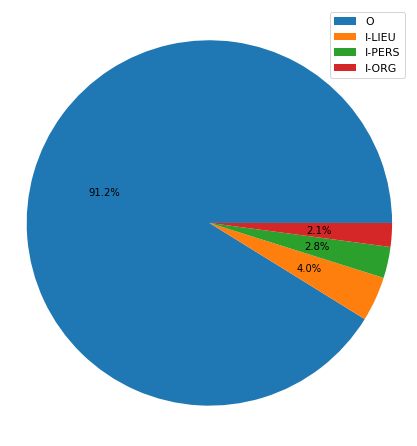

In [0]:
# Repartition of words into categories

labels=df["labels"].value_counts().index
fig1, ax1 = plt.subplots(figsize=(8, 6))
fig1.subplots_adjust(0.3,0,1,1)
ax1.pie(df["labels"].value_counts().values, autopct='%1.1f%%')
ax1.axis('equal')
plt.legend(loc='best',
           prop={'size': 11},
           labels = labels
           )
fig1 = plt.gcf()
plt.show()
plt.show()

We notice that the dataset is unbalanced. It contains a majority of "O" (91.2%).
"I-LIEU" is twice as present as the "I-PERS" and "I-ORG" classes. It would be interesting to consider a rebalancing of the classes.

In [0]:
# Create directory images if necessary
# Export fig as a png file

if not os.path.exists("./images"):
    os.mkdir("./images")
fig1.savefig("./images/repartition.png")

# Testing available NERmodels of simpletransformer.

First, we will test each family of models with the models proposed in the documentation. Here is the list : 

- BERT : bert / **bert-base-cased** 
- CamemBERT : camembert / **camembert-base** 
- RoBERTa : roberta / **roberta-base** 
- DistilBERT : distilbert / **distilbert-base-cased** 
- ELECTRA : electra / **google/electra-base-discriminator** 
- XLM-RoBERTa : xlmroberta / **xlm-roberta-base** 


## Functions

We encountered problems with the saturation of the graphics card. This function allows you to obtain the percentage of allocated memory and cache used. 

In [0]:
def check_cuda_freespace() : 
  """ check cuda memory"""

  t = torch.cuda.get_device_properties(0).total_memory
  c = torch.cuda.memory_cached(0)
  a = torch.cuda.memory_allocated(0)
  f = ((c)/t)*100  # free space
  print("Cuda memory cached : " , c)
  print("Cuda memory allocated : " , c)
  print("Cuda free memory : " , f)

In order to avoid saturation, we have created a function that allows you to empty part of the graphics card cache.

In [0]:
def dump_tensors(gpu_only=True):
  """To avoid GPU'S saturation, this function flush GPU's memory. It deletes tensors wich take space.

  """
  total_size = 0
  for obj in gc.get_objects():
      try:
          if torch.is_tensor(obj):
              if not gpu_only or obj.is_cuda:
                  del obj
                  gc.collect()
                  torch.cuda.empty_cache()
          elif hasattr(obj, "data") and torch.is_tensor(obj.data):
              if not gpu_only or obj.is_cuda:
                  del obj
                  gc.collect()
                  torch.cuda.empty_cache()
      except Exception as e:
          pass

In [0]:
def modeling_train_eval(train_df , eval_df , algotype , algo, results_df) :
  """ This function will train and eval given an NERmodel
  Parameters
  ----------

  train_df : dataframe
    Training dataframe

  eval_df : dataframe
    Eval dataframe

  algotype : str
    It represents a family of model
    Possible value : BERT, CamemBERT, RoBERTa, DistilBERT, ELECTRA, XLM-RoBERTa 

  algo : str
    It is a model associated with a family. Its value depends on algotype

  results_df : dataframe
    Dataframe where results will be save
  """

  print("###################\t", algotype , " -- ", algo ,"\t###################")

  renamed_algo = algo.replace("/","-")
  path_output = "./out/models/"+renamed_algo # path where results and model will be saved

  # if directory doesn't exist, it will be create
  if not os.path.exists(path_output):
    os.mkdir(path_output)

  try : 
    print("################### MODEL CREATION\t", algotype , " -- ", algo ,"\t###################")
    model = NERModel(algotype, algo , args={'overwrite_output_dir': True, 'reprocess_input_data': True}, labels=tags)
    print("################### MODEL TRAINING\t", algotype , " -- ", algo ,"\t###################")
    model.train_model(train_df, output_dir = path_output)

    print("################### MODEL EVAL\t", algotype , " -- ", algo ,"\t###################")
    result, model_outputs, predictions = model.eval_model(eval_df, output_dir = path_output )

    # adding type_algo's name and algo's name
    result["type_algo"] = algotype
    result["algo"] = algo

    print("################### APPENDING RESULTS\t", algotype , " -- ", algo ,"\t###################")
    # appending results to a dataframe
    results_df = results_df.append(result, ignore_index = True)

#  except RuntimeError as e :
#    dump_tensors()
  
  except (AttributeError, OSError) as err : 
    try:
      shutil.rmtree(path_output)
      del model
      
    except NameError as error:
      pass

  return results_df

## Training and evaluation of each Model 

The performance of the models will be written in the dataframe results.
It will be composed of loss, f1_score, precision and recall for each model



In [0]:
global results
results = pd.DataFrame(columns = ['eval_loss','f1_score','precision','recall', "type_algo", "algo"]) 

The next cell allows you to run function x by looping through the model family and model lists.

In [0]:
l_algotype = [ "bert" , "camembert" , "roberta" , "distilbert" , "electra" , "xlmroberta"] # family of models
l_algo = [ "bert-base-cased", "camembert-base" , "roberta-base" ,
          "distilbert-base-cased" , "google/electra-base-discriminator" , "xlm-roberta-base"] # model names

results = [modeling_train_eval(train_df , eval_df, x, y, results) for x, y in zip(l_algotype, l_algo)][0]

# round values to 2 significant digits
results = round(results, 2)

As we have memory saturation problems, we decided to make backups of the dataframe results. They will allow us to write the rest of the results after the graphics card is saturated.

In [0]:
# export results
results.to_csv("./out/results.csv", sep = "," , index = False )

In [0]:
results = pd.read_csv("./out/results.csv" , sep = "," )

In [0]:
results

,eval_loss,f1_score,precision,recall,type_algo,algo
0,0.20,0.67,0.67,0.67,bert,bert-base-cased
1,0.20,0.72,0.73,0.72,camembert,camembert-base
2,0.23,0.60,0.60,0.60,roberta,roberta-base
3,0.21,0.62,0.63,0.61,distilbert,distilbert-base-cased
4,0.27,0.39,0.44,0.35,electra,google/electra-base-discriminator
5,0.20,0.70,0.68,0.71,xlmroberta,xlm-roberta-base


Only Camembert and XMLRoberta stand out from the others. We will therefore test some of the different models (Camembert and XMLroberta) made available: https://huggingface.co/models

## Focus on Camembert

As in the previous part "Training and evaluation of each Model", we will test models. This time, we will test the camembert model family in depth.

In [0]:
global camembert_results
camembert_results = pd.DataFrame(columns = ['eval_loss','f1_score','precision','recall', "type_algo", "algo"])

In [0]:
l_camembert = ["illuin/camembert-large-fquad" ,
               "fmikaelian/camembert-base-squad", "illuin/camembert-base-fquad", "camembert/camembert-base",
               "camembert/camembert-base-ccnet", "camembert/camembert-base-oscar-4gb", "camembert/camembert-base-ccnet-4gb",
               "camembert/camembert-base-wikipedia-4gb"] # [ "idb-ita/gilberto-uncased-from-camembert" , "jplu/tf-camembert-base" ,
               #"camembert/camembert-large" , "fmikaelian/camembert-base-fquad" , 


camembert_results = [modeling_train_eval(train_df  , eval_df,"camembert", x , camembert_results ) for x in l_camembert][0]

### Processing results

During our "simpletransformer" manipulation, we discovered the "output_dir" parameter. It allows us to save the model, as well as its test results, in a folder that we defined. We created one folder per model.

Afterwards, we retrieve all the "eval_results.txt" files where our evaluation metrics are saved. Finally, we add them to the "camembert_results" dataframe.

In [0]:
import os
from os.path import isfile, join, isdir

def get_files_path(directory, paths):
    for item in os.listdir(directory):
        if isfile(join(directory, item)) and item == "eval_results.txt":
            paths.append(directory + '/' +item)
        elif isdir(directory+item):
            get_files_path(directory + item, paths)
    return paths

directory_to_search = "./out/models/"
paths = get_files_path(directory_to_search , [])

In [0]:
camembert_results = pd.DataFrame()
for path in paths : 
  tmp = pd.read_csv(path, sep = "=", header = None).T
  tmp.columns = list(tmp.iloc[0,:])
  tmp.drop(tmp.index[0], inplace = True)
  tmp["type_algo"] = "camembert"
  tmp["algo"] = (path.split("/")[3])
  camembert_results = camembert_results.append(tmp)

# round values to 2 significant digits
camembert_results = round(camembert_results, 2)

In [0]:
# export camembert results
camembert_results.to_csv(r"./out/camembert_results.csv", sep = ",", index =False)

In [0]:
camembert_results = pd.read_csv(r"./out/camembert_results.csv", sep = ",")

In [0]:
camembert_results.sort_values(by = "f1_score ", ascending = False)

,eval_loss,f1_score,precision,recall,type_algo,algo
1,0.18,0.76,0.74,0.77,camembert,camembert-camembert-large
8,0.19,0.74,0.75,0.73,camembert,camembert-camembert-base-oscar-4gb
2,0.19,0.73,0.73,0.72,camembert,fmikaelian-camembert-base-fquad
7,0.19,0.73,0.74,0.73,camembert,camembert-camembert-base-ccnet
9,0.19,0.72,0.73,0.72,camembert,camembert-camembert-base-ccnet-4gb
3,0.21,0.71,0.71,0.71,camembert,illuin-camembert-large-fquad
4,0.20,0.71,0.72,0.71,camembert,fmikaelian-camembert-base-squad
10,0.20,0.71,0.72,0.70,camembert,camembert-camembert-base-wikipedia-4gb
5,0.21,0.67,0.70,0.64,camembert,illuin-camembert-base-fquad
6,0.21,0.67,0.70,0.64,camembert,camembert-camembert-base


## Predictions

The "camembert/camembert-wide" model gave the best results.
We decided to test it with sentences of our choice by introducing traps such as "Pierre" and "pierre".

In [0]:
model = NERModel(r"camembert", r"./out/models/camembert-camembert-large", labels = tags)

/usr/local/lib/python3.6/dist-packages/simpletransformers/ner/ner_model.py:170: UserWarning:

use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.



In [0]:
predictions, raw_outputs = model.predict(["Pierre et Paul vivaient à Paris. Ils ont passé leur journée à casser une pierre.\
 Mais ils travaillent à La Défense. Une Marguerite. Une Table"])

In [0]:
print(predictions)

[[{'Pierre': 'I-PERS'}, {'et': 'O'}, {'Paul': 'I-PERS'}, {'vivaient': 'O'}, {'à': 'O'}, {'Paris.': 'I-LIEU'}, {'Ils': 'O'}, {'ont': 'O'}, {'passé': 'O'}, {'leur': 'O'}, {'journée': 'O'}, {'à': 'O'}, {'casser': 'O'}, {'une': 'O'}, {'pierre.': 'O'}, {'Mais': 'O'}, {'ils': 'O'}, {'travaillent': 'O'}, {'à': 'O'}, {'La': 'I-LIEU'}, {'Défense.': 'I-LIEU'}, {'Une': 'O'}, {'Marguerite.': 'I-PERS'}, {'Une': 'O'}, {'Table': 'O'}]]


# Classification report

The purpose of this section  is to evaluate the performance of the entity recognition models **by entity**. For example, to detect if models struggle recognizing a certain entity in particular.

We start by loading the model "camembert-camember-large" that was previouly saved and rerun the *eval_model* function to 

In [0]:
model = NERModel(r"camembert", r"./out/models/camembert-camembert-large", labels = tags)

In [0]:
result, model_outputs, predictions = model.eval_model(eval_df,output_dir = "./tests" )


In [0]:
print("F1-score : ", result["f1_score"])
# print(predictions)


F1-score :  0.7829347385488448


To be able to use the seqeval metrics classification report, y_true have to be created, based on the eval_df, in the right format which is a list of lists of tags (one list per sentence). We create this list of list grouping "labels" by "sentence_id".

In [0]:
df_grouped_eval = pd.DataFrame(eval_df[["sentence_id", "labels"]].groupby("sentence_id")["labels"].apply(list))
print(df_grouped_eval.head())
y_true = df_grouped_eval["labels"].tolist()

                                                        labels
sentence_id                                                   
2            [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
4            [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
11                           [O, O, O, O, O, O, O, O, O, O, O]
12                                    [O, O, O, O, O, O, O, O]
17                                          [O, O, O, O, O, O]


In [0]:
print("F1-score : ",f1_score(y_true, predictions))
print("Accuracy : ", accuracy_score(y_true, predictions))
print("Classification Report : \n", classification_report(y_true, predictions))

F1-score :  0.029169181251257288
Accuracy :  0.847561606422379
Classification Report : 
            precision    recall  f1-score   support

     LIEU       0.03      0.03      0.03      2095
      ORG       0.02      0.02      0.02       738
     PERS       0.03      0.03      0.03      2093

micro avg       0.03      0.03      0.03      4926
macro avg       0.03      0.03      0.03      4926



In [0]:
# previoulsy calculated f1-score : 0.12 ..
f1_score(y_true, predictions)

0.11958333333333333

In [0]:
# previoulsy calculated accuracy : 0.86 ..
accuracy_score(y_true, predictions)

0.8577455335740996

In [0]:
len(y_true)

5738

In [0]:
len(predictions)

5738